$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [2]:
import cs236781.plot as plot
import cs236781.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/kali/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/kali/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/kali/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


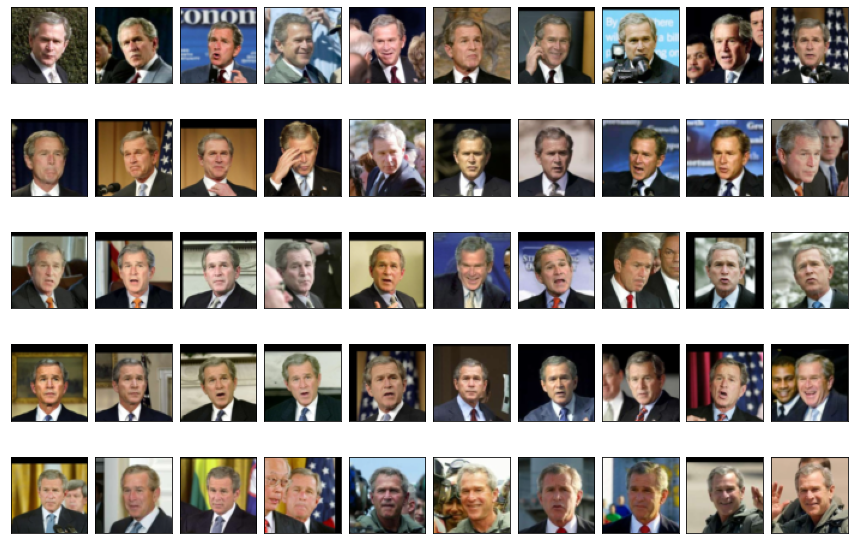

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [6]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (dsc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (cnn): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [8]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [9]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

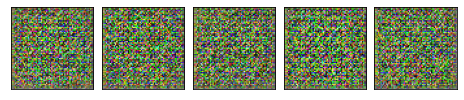

In [10]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw3/answers.py` module.

In [11]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 8, 'z_dim': 100, 'data_label': 1, 'label_noise': 0.2, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'betas': (0.5, 0.999)}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'betas': (0.5, 0.999)}}


**TODO**:
1. Implement the `save_checkpoint` function in the `hw3.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

--- EPOCH 1/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:39<00:00,  1.48s/it]
Discriminator loss: 0.2226154575986204
Generator loss:     10.399013006865088


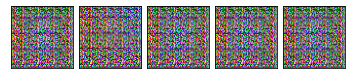

--- EPOCH 2/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:51<00:00,  1.66s/it]
Discriminator loss: 0.32406483643424155
Generator loss:     10.796153659251198


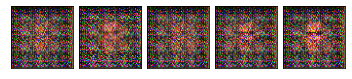

--- EPOCH 3/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:40<00:00,  1.50s/it]
Discriminator loss: 0.6249632680538431
Generator loss:     7.866348905349845


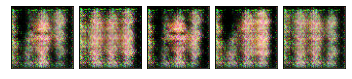

--- EPOCH 4/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:53<00:00,  1.70s/it]
Discriminator loss: 0.7597085722346804
Generator loss:     4.140996360956733


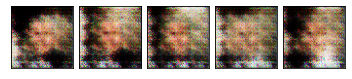

--- EPOCH 5/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [02:04<00:00,  1.86s/it]
Discriminator loss: 0.7992192764780415
Generator loss:     4.1413471245053985


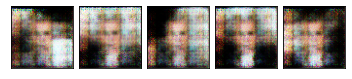

--- EPOCH 6/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [02:41<00:00,  2.40s/it]
Discriminator loss: 0.760242141227224
Generator loss:     3.8490008097976003


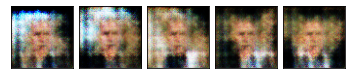

--- EPOCH 7/100 ---
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:25<00:00,  1.27s/it]
Discriminator loss: 0.6488763174014305
Generator loss:     4.048653104412022


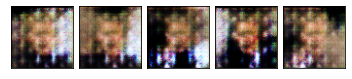

--- EPOCH 8/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.07s/it]
Discriminator loss: 0.692744659287716
Generator loss:     4.1238828772929175


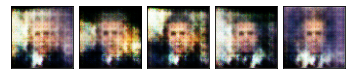

--- EPOCH 9/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:10<00:00,  1.06s/it]
Discriminator loss: 0.7140244154342964
Generator loss:     3.651231741727288


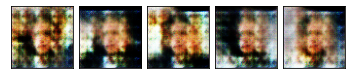

--- EPOCH 10/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:13<00:00,  1.10s/it]
Discriminator loss: 0.6570371590109904
Generator loss:     4.1205917472269995


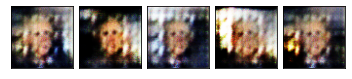

--- EPOCH 11/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:17<00:00,  1.16s/it]
Discriminator loss: 0.7654145942695105
Generator loss:     3.452788523773649


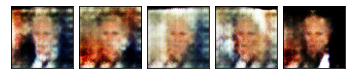

--- EPOCH 12/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:13<00:00,  1.10s/it]
Discriminator loss: 0.6773354987155146
Generator loss:     3.9122310796780373


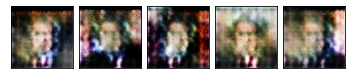

--- EPOCH 13/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:14<00:00,  1.11s/it]
Discriminator loss: 0.686968584558857
Generator loss:     3.6455368479685997


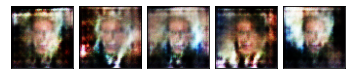

--- EPOCH 14/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:14<00:00,  1.11s/it]
Discriminator loss: 0.6736044735272428
Generator loss:     3.794376923077142


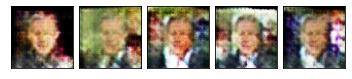

--- EPOCH 15/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:21<00:00,  1.21s/it]
Discriminator loss: 0.6158740751778902
Generator loss:     3.928209099306989


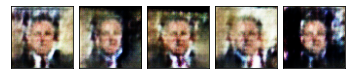

--- EPOCH 16/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.07s/it]
Discriminator loss: 0.7055960969248815
Generator loss:     3.748022351691972


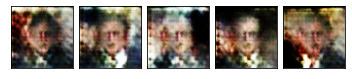

--- EPOCH 17/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.07s/it]
Discriminator loss: 0.7214510603182351
Generator loss:     4.0355255336903815


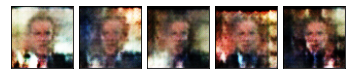

--- EPOCH 18/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:12<00:00,  1.08s/it]
Discriminator loss: 0.5925487618504176
Generator loss:     3.592918805222013


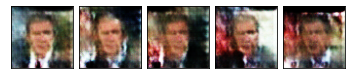

--- EPOCH 19/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.07s/it]
Discriminator loss: 0.6489447415319841
Generator loss:     3.7618876855764816


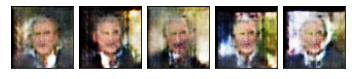

--- EPOCH 20/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:12<00:00,  1.08s/it]
Discriminator loss: 0.6137689489926865
Generator loss:     3.728848683300303


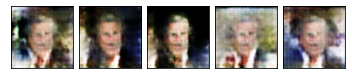

--- EPOCH 21/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:20<00:00,  1.20s/it]
Discriminator loss: 0.533989105373621
Generator loss:     4.0369778053084415


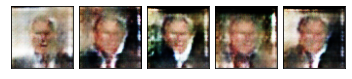

--- EPOCH 22/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:13<00:00,  1.09s/it]
Discriminator loss: 0.6231796376184741
Generator loss:     4.205059199190852


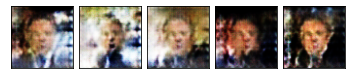

--- EPOCH 23/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:14<00:00,  1.11s/it]
Discriminator loss: 0.5462197742577809
Generator loss:     3.6763485750155662


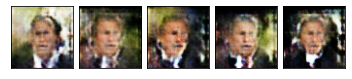

--- EPOCH 24/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:15<00:00,  1.12s/it]
Discriminator loss: 0.5820786693870131
Generator loss:     3.934920588536049


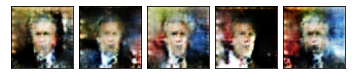

--- EPOCH 25/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:14<00:00,  1.11s/it]
Discriminator loss: 0.48068115604457573
Generator loss:     3.8703388989861334


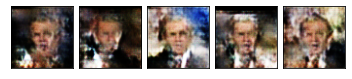

--- EPOCH 26/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:12<00:00,  1.08s/it]
Discriminator loss: 0.5212051019406141
Generator loss:     4.146393323122566


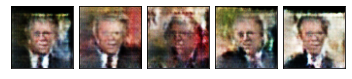

--- EPOCH 27/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.06s/it]
Discriminator loss: 0.47505673365806467
Generator loss:     4.043247221121147


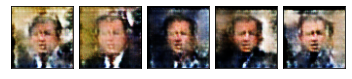

--- EPOCH 28/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.07s/it]
Discriminator loss: 0.48975709870235246
Generator loss:     3.9668766687165444
Saved checkpoint.


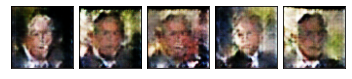

--- EPOCH 29/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:14<00:00,  1.12s/it]
Discriminator loss: 0.41483799612789013
Generator loss:     4.285565899379217


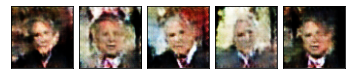

--- EPOCH 30/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:12<00:00,  1.08s/it]
Discriminator loss: 0.47531898019473945
Generator loss:     4.09228524165367


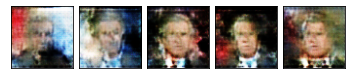

--- EPOCH 31/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:10<00:00,  1.06s/it]
Discriminator loss: 0.4484067074676503
Generator loss:     4.203467078173339


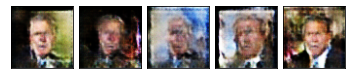

--- EPOCH 32/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.06s/it]
Discriminator loss: 0.4615772899184654
Generator loss:     4.129581930032417


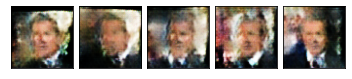

--- EPOCH 33/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.06s/it]
Discriminator loss: 0.34161930709187666
Generator loss:     4.388808421234586


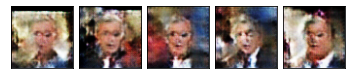

--- EPOCH 34/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:12<00:00,  1.08s/it]
Discriminator loss: 0.4297226559259553
Generator loss:     4.408588472586959


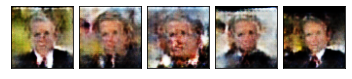

--- EPOCH 35/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.06s/it]
Discriminator loss: 0.38908996421899367
Generator loss:     4.403439705051593


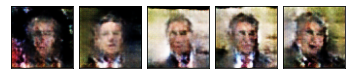

--- EPOCH 36/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:14<00:00,  1.11s/it]
Discriminator loss: 0.5031480472812901
Generator loss:     4.302793388046435


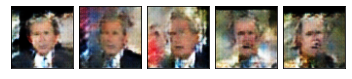

--- EPOCH 37/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.06s/it]
Discriminator loss: 0.3036700967532485
Generator loss:     4.256853963012126


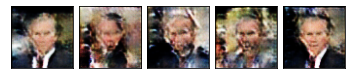

--- EPOCH 38/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.06s/it]
Discriminator loss: 0.44352790401942693
Generator loss:     4.935855774737116


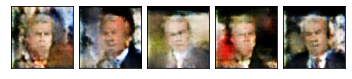

--- EPOCH 39/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:15<00:00,  1.13s/it]
Discriminator loss: 0.34675667462731474
Generator loss:     4.575066045149049


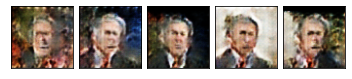

--- EPOCH 40/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:10<00:00,  1.06s/it]
Discriminator loss: 0.40445677874915636
Generator loss:     4.601134561780674


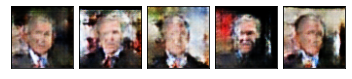

--- EPOCH 41/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:12<00:00,  1.08s/it]
Discriminator loss: 0.35126391709295673
Generator loss:     4.461568499678996


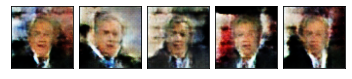

--- EPOCH 42/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.06s/it]
Discriminator loss: 0.31365142673698826
Generator loss:     4.84396594140067


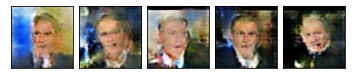

--- EPOCH 43/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:12<00:00,  1.08s/it]
Discriminator loss: 0.33251275033203526
Generator loss:     4.469906568527222


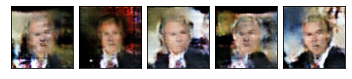

--- EPOCH 44/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.06s/it]
Discriminator loss: 0.279036117523019
Generator loss:     4.753364780055943


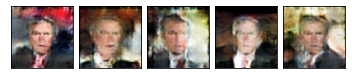

--- EPOCH 45/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:10<00:00,  1.06s/it]
Discriminator loss: 0.42701762508767754
Generator loss:     5.096534817966063


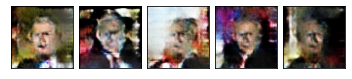

--- EPOCH 46/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:12<00:00,  1.08s/it]
Discriminator loss: 0.40647909551191685
Generator loss:     4.550182789119322


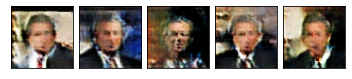

--- EPOCH 47/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.06s/it]
Discriminator loss: 0.24964745699970134
Generator loss:     4.565602247394732


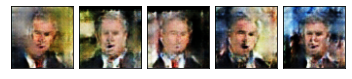

--- EPOCH 48/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:12<00:00,  1.09s/it]
Discriminator loss: 0.26656937849388196
Generator loss:     4.488548634657219


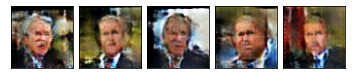

--- EPOCH 49/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:13<00:00,  1.09s/it]
Discriminator loss: 0.2868878970951287
Generator loss:     5.13614484089524


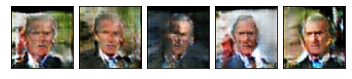

--- EPOCH 50/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:10<00:00,  1.06s/it]
Discriminator loss: 0.2893540797504916
Generator loss:     4.9686783374245485


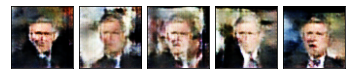

--- EPOCH 51/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.07s/it]
Discriminator loss: 0.4205938978537695
Generator loss:     5.042785594712442


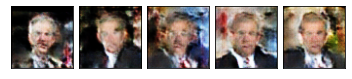

--- EPOCH 52/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.06s/it]
Discriminator loss: 0.39453655745444904
Generator loss:     5.26520986521422


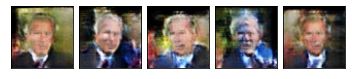

--- EPOCH 53/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:13<00:00,  1.09s/it]
Discriminator loss: 0.3967029097587315
Generator loss:     4.636836155137019


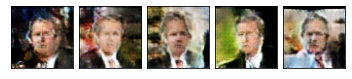

--- EPOCH 54/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:12<00:00,  1.08s/it]
Discriminator loss: 0.2517954114435324
Generator loss:     4.709473912395648


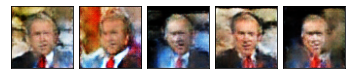

--- EPOCH 55/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.07s/it]
Discriminator loss: 0.21090908240137704
Generator loss:     4.746104042921493


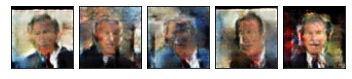

--- EPOCH 56/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:13<00:00,  1.10s/it]
Discriminator loss: 0.2222719030704961
Generator loss:     5.1047546383160265


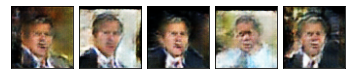

--- EPOCH 57/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:12<00:00,  1.09s/it]
Discriminator loss: 0.2371100701892109
Generator loss:     5.161920148934891


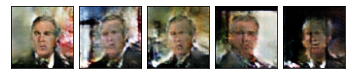

--- EPOCH 58/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:13<00:00,  1.09s/it]
Discriminator loss: 0.23250969593871884
Generator loss:     5.226165280413272


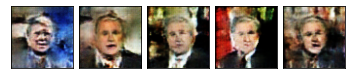

--- EPOCH 59/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:13<00:00,  1.10s/it]
Discriminator loss: 0.1713197364735959
Generator loss:     5.229283902182508


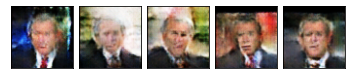

--- EPOCH 60/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:13<00:00,  1.09s/it]
Discriminator loss: 0.3744734670244046
Generator loss:     5.22563999802319


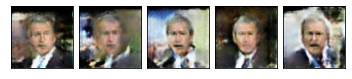

--- EPOCH 61/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:15<00:00,  1.13s/it]
Discriminator loss: 0.21818367603109845
Generator loss:     5.034501529451626


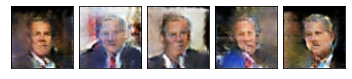

--- EPOCH 62/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:14<00:00,  1.10s/it]
Discriminator loss: 0.2961589781595255
Generator loss:     5.973364061384059


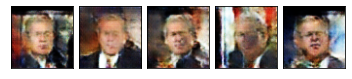

--- EPOCH 63/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:12<00:00,  1.09s/it]
Discriminator loss: 0.24063466767321773
Generator loss:     4.941025922547525


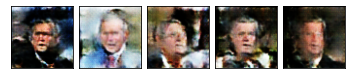

--- EPOCH 64/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:16<00:00,  1.14s/it]
Discriminator loss: 0.23336398223442817
Generator loss:     4.79269886728543
Saved checkpoint.


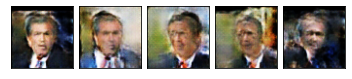

--- EPOCH 65/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.06s/it]
Discriminator loss: 0.2037594327564115
Generator loss:     5.494116355234118


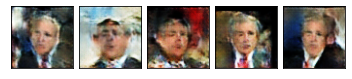

--- EPOCH 66/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.07s/it]
Discriminator loss: 0.28042146480127944
Generator loss:     5.429578503566002


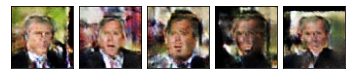

--- EPOCH 67/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:12<00:00,  1.08s/it]
Discriminator loss: 0.2380366637857992
Generator loss:     5.586613768961892


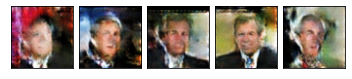

--- EPOCH 68/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.06s/it]
Discriminator loss: 0.24321508038538828
Generator loss:     5.506548023935574


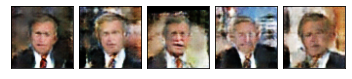

--- EPOCH 69/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:12<00:00,  1.08s/it]
Discriminator loss: 0.19822439951683157
Generator loss:     5.6423968984119925


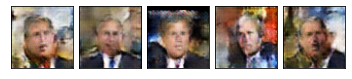

--- EPOCH 70/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.07s/it]
Discriminator loss: 0.19567888513652246
Generator loss:     5.2913757936278385


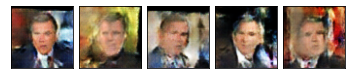

--- EPOCH 71/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:12<00:00,  1.08s/it]
Discriminator loss: 0.216128641795089
Generator loss:     5.444126164735253


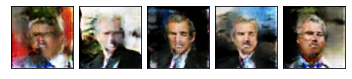

--- EPOCH 72/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.07s/it]
Discriminator loss: 0.1359927723768042
Generator loss:     5.344446449137446


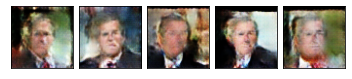

--- EPOCH 73/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:12<00:00,  1.08s/it]
Discriminator loss: 0.20982019202922708
Generator loss:     5.672997513813759


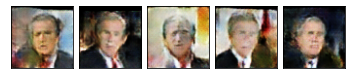

--- EPOCH 74/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:14<00:00,  1.11s/it]
Discriminator loss: 0.16212283858834808
Generator loss:     5.464307156961356


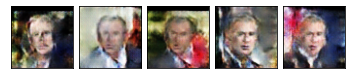

--- EPOCH 75/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.07s/it]
Discriminator loss: 0.36618489243868574
Generator loss:     6.051519253360691


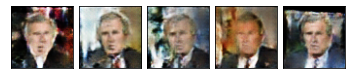

--- EPOCH 76/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.07s/it]
Discriminator loss: 0.17745266220907666
Generator loss:     4.925476590199257


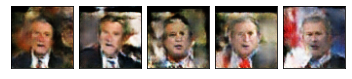

--- EPOCH 77/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:10<00:00,  1.06s/it]
Discriminator loss: 0.18689542805859402
Generator loss:     5.445575205247794


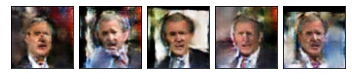

--- EPOCH 78/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:10<00:00,  1.05s/it]
Discriminator loss: 0.1568165964155055
Generator loss:     5.459341437069337


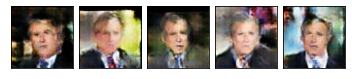

--- EPOCH 79/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.07s/it]
Discriminator loss: 0.16645404059829108
Generator loss:     5.654817463746712


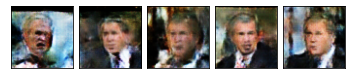

--- EPOCH 80/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:09<00:00,  1.04s/it]
Discriminator loss: 0.24319110466028326
Generator loss:     5.824600757057987


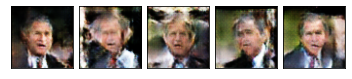

--- EPOCH 81/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:19<00:00,  1.18s/it]
Discriminator loss: 0.1486799336080231
Generator loss:     5.589747959108495


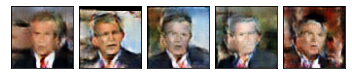

--- EPOCH 82/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:28<00:00,  1.32s/it]
Discriminator loss: 0.1359346567917226
Generator loss:     5.59498687644503


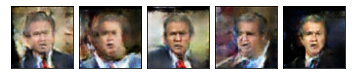

--- EPOCH 83/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:16<00:00,  1.14s/it]
Discriminator loss: 0.3582810720623429
Generator loss:     6.1349239803072235


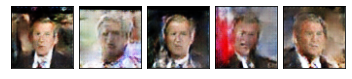

--- EPOCH 84/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:13<00:00,  1.09s/it]
Discriminator loss: 0.21791031133772723
Generator loss:     5.550275245709206


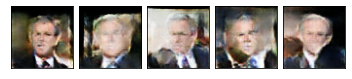

--- EPOCH 85/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:12<00:00,  1.09s/it]
Discriminator loss: 0.1460703068982754
Generator loss:     5.643578984844151


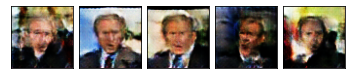

--- EPOCH 86/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:14<00:00,  1.11s/it]
Discriminator loss: 0.1680278676881719
Generator loss:     5.423344418184081


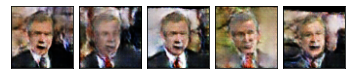

--- EPOCH 87/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:10<00:00,  1.05s/it]
Discriminator loss: 0.13634364540452387
Generator loss:     6.287931374649503


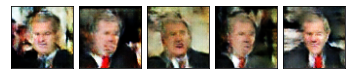

--- EPOCH 88/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:10<00:00,  1.05s/it]
Discriminator loss: 0.15707427296620696
Generator loss:     6.208204162654592


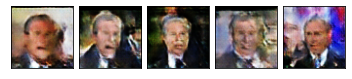

--- EPOCH 89/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:15<00:00,  1.13s/it]
Discriminator loss: 0.23691063135195134
Generator loss:     6.708966758713793


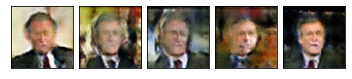

--- EPOCH 90/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:18<00:00,  1.17s/it]
Discriminator loss: 0.1935963678215422
Generator loss:     5.781576846962545


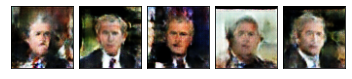

--- EPOCH 91/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:15<00:00,  1.13s/it]
Discriminator loss: 0.1911312595232209
Generator loss:     5.672198094538788
Saved checkpoint.


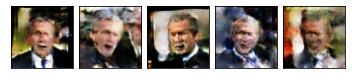

--- EPOCH 92/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:20<00:00,  1.20s/it]
Discriminator loss: 0.11797445981916208
Generator loss:     5.658509987503735
Saved checkpoint.


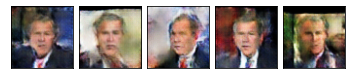

--- EPOCH 93/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:13<00:00,  1.10s/it]
Discriminator loss: 0.06029647434436118
Generator loss:     5.692577867365595


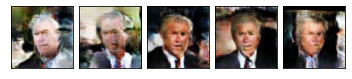

--- EPOCH 94/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.06s/it]
Discriminator loss: 0.21785901588346088
Generator loss:     5.82088153397859


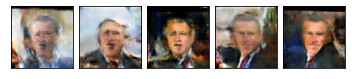

--- EPOCH 95/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.07s/it]
Discriminator loss: 0.11724033395745861
Generator loss:     5.538199930048701


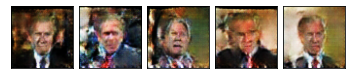

--- EPOCH 96/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:11<00:00,  1.06s/it]
Discriminator loss: 0.12432931063335333
Generator loss:     6.089405600704364


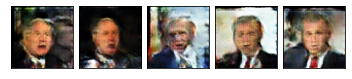

--- EPOCH 97/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:14<00:00,  1.11s/it]
Discriminator loss: 0.1921722201991882
Generator loss:     6.962398450766036


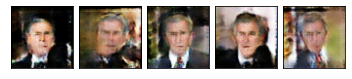

--- EPOCH 98/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [01:58<00:00,  1.76s/it]
Discriminator loss: 0.12687940124088704
Generator loss:     6.596022196670077


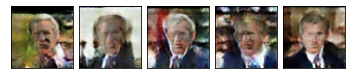

--- EPOCH 99/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [02:23<00:00,  2.14s/it]
Discriminator loss: 0.2868398177757192
Generator loss:     6.26818527392487


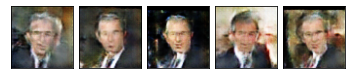

--- EPOCH 100/100 ---
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [02:32<00:00,  2.28s/it]
Discriminator loss: 0.1492465426450345
Generator loss:     6.200201539850947


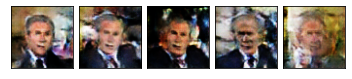

In [12]:
import IPython.display
import tqdm
from hw3.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device,)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

*** Images Generated from best model:


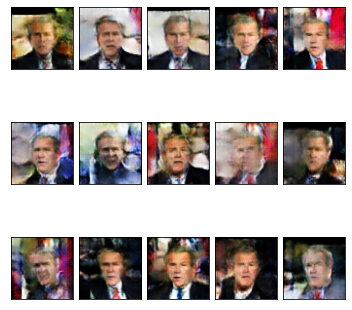

In [13]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [8]:
from cs236781.answers import display_answer
import hw3.answers as answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [9]:
display_answer(answers.part3_q1)


**Your answer:**
In the training phase, we only train the discriminator alone, and in this phase we sample the images accordingly. 
We don't want these samples to affect the gradient of the generator, so we need to separate these samples from the backpropagation process. 
This can happen even if we don't intend to. 
Therefore, when we train the generator and freeze the discriminator, we preserve these gradients to improve the sampling power of the generator.



### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [10]:
display_answer(answers.part3_q2)


**Your answer:**
1) We shouldn't decide to stop training just because the generator loss is below a certain threshold, because if we look at the results, we can see that a low loss rate doesn't mean that the generator produces sound images=. Loss is defined by the ability of the discriminator to detect fake images, it does not measure sample quality. Sometimes the discriminator is not very good and the generator produces bad samples, but these samples can fool the discriminator.

2) If the discriminator loss remains constant and the generator loss decreases, it means that the discriminator cannot correctly identify real and fake samples. Generator improved and created better samples.


### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [4]:
display_answer(answers.part3_q3)



**Your answer:**
It can be said that the images we generate with VAE are smoother and more focused on human faces. 
If we compare it to the VAE, those generated by the GAN are more noisy and have multiple colors. 
This might be due to the differences in architecture and loss function between both networks.
For example, if we compare the loss functions of these two: the VAE loss function is directly related to the dataset, unlike the GAN loss function, it is from a game theory perspective and has no direct relationship with the dataset, so the general picture related refers to the entire image, including the background and its colors. 
In the VAE dataset, we have a common face, and because of its architecture and care for mutual information in the input and decoded images, it preserves the common features in the resulting decoded images without preserving the background and its color .
